In [15]:
%load_ext autoreload
%autoreload

import pandas as pd
import numpy as np
from typing import List, Optional
import pickle

import catboost as catb
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import time
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
import shap

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from scipy.stats import skew, kurtosis
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from mlxtend.classifier import StackingCVClassifier

from utils.utils import get_input
from utils.feature_generators import get_expanding_means

pd.set_option("display.max_columns", None)
seed = 1234123

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
def roc_auc_cv(model,X,y):
    """Расчет roc-auc метрики на кросс-валидации по 5 фолдам"""
    auc_score = cross_val_score(model,X,y,scoring="roc_auc", cv=5)
    return auc_score

In [19]:
class FeatureTransformer(BaseEstimator,TransformerMixin):
    
    """
    Очистка данных. Создание новых признаков для каждой таблицы.
    Склеивание отобранных признаков в один датасет.
    """
    def __init__(self,
                 client_profile,
                 history,
                 bki,
                 payments,
                 id_col='application_number'):
        
        self.client_profile = self.create_client_profile_features(client_profile)
        self.history = self.create_history_features(history)
        self.bki = self.create_bki_features(bki)
        self.payments = self.create_payments_features(payments)
#         self.spec = [self.client_profile]
        self.spec = [self.client_profile, self.history, self.bki, self.payments]
#         self.spec = [self.client_profile]
        self.id_col = id_col
        
        
    def generate_cat_aggs(self,
                          X: pd.DataFrame,
                          features: list,
                          id_col: str) -> pd.DataFrame:
        """
        Построение агрегаций для категориальных признаков.
        Для категориальных признаков считаются счетчики для
        каждого значения категории и среднее значение счетчика
        для каждого значения категории.

        Parameters
        ----------
        X: pandas.core.frame.DataFrame
            Выборка для построения агрегаций.


        features: List[str]
            Список с названием признаков, для которых произвести
            группировку.

        id_col: str
            Наименование столбца для агрегации

        Returns
        -------
        new_features, test: pandas.core.frame.DataFrame
            Закодированные категориальные признаки с добавленными агрегациями.

        """

        categorical = X[features].copy()
        categorical = self.encode_labels(categorical)
        columns_to_agg = categorical.columns

        categorical.loc[:, id_col] = X[id_col]
        group = categorical.groupby(id_col)
        new_features = group.agg({col: ["mean", "sum"] for col in columns_to_agg})

        new_features.columns = [f"{feature}_{name.lower()}" for feature, name in new_features]
        new_features.columns = [col.replace("maan", "ratio") for col in new_features.columns]
        new_features.columns = [col.replace("sum", "total") for col in new_features.columns]
        new_features = new_features.reset_index()
        return new_features
    
    
    def generate_numerical_aggs(self,
                                X: pd.DataFrame,
                                groupby_id: str,
                                aggs: dict,
                                prefix: Optional[str] = None,
                                suffix: Optional[str] = None
                               ) -> pd.DataFrame:
        """
        Построение агрегаций для числовых признаков.

        Parameters
        ----------
        X: pandas.core.frame.DataFrame
            Выборка для построения агрегаций.

        groupby_id: str
            Название ключа, по которому нужно произвести группировку.

        aggs: dict
            Словарь с названием признака и списка функций.
            Ключ словаря - название признака, который используется для
            вычисления агрегаций, значение словаря - список с названием
            функций для вычисления агрегаций.

        prefix: str, optional, default = None
            Префикс для названия признаков.
            Опциональный параметр, по умолчанию, не используется.

        suffix: str, optional, default = None
            Суффикс для названия признаков.
            Опциональный параметр, по умолчанию, не используется.

        Returns
        -------
        stats: pandas.core.frame.DataFrame
            Выборка с рассчитанными агрегациями.

        """
        if not prefix:
            prefix = ""
        if not suffix:
            suffix = ""

        data_grouped = X.groupby(groupby_id)
        stats = data_grouped.agg(aggs)
        stats.columns = [f"{prefix}{feature}_{stat}{suffix}".lower() for feature, stat in stats]
        stats = stats.reset_index()
        return stats
  
    def encode_labels(self, X: pd.DataFrame) -> pd.DataFrame:  
        """
        Применяет Label Encoding ко всем категориальным признакам
        
        Parameters
        ----------
        X: pandas.core.frame.DataFrame
            Матрица с категориальными признаками для преобразования. 
            Числовые признаки остаются без изменнеий.
        """
        
        for cat_colname in X.select_dtypes(include='object').columns:
            le = LabelEncoder()
            transformed = le.fit_transform(X[cat_colname].fillna('null'))
            X[cat_colname] = transformed
        return X        
        
        
    def create_client_profile_features(self, X, copy: bool = True):
        """
        Создание признаков на основе профиля клиентов.

        Parameters
        ----------
        X: pandas.core.frame.DataFrame
            Матрица признаков с исходным профилем клиента.

        copy: bool, optional, default = True
            Флаг использования копии датафрейма X.
            Опциональный параметр, по умолчанию, равен True.

        Returns
        -------
        res: pandas.core.frame.DataFrame
            Расширенная матрица признаков с профилем клиентов.

        """
        if copy:
            X = X.copy()
        
        
        X["days_on_last_job"] = X["days_on_last_job"].replace(365243, np.nan)
        bki_flags = [flag for flag in X.columns if "amt_req_credit_bureau" in flag]
        X["bki_requests_count"] = X[bki_flags].sum(axis=1)
        X["bki_kurtosis"] = X[bki_flags].kurtosis(axis=1)

        # Отношение внесенной суммы кредита к его размеру
        tmp = (X["external_scoring_rating_1"] +
                                  X["external_scoring_rating_2"] +
                                  X["external_scoring_rating_3"]
                                 )
        X["mean_scoring_sum"] = tmp/3 


        X["external_scoring_prod"] = X["external_scoring_rating_1"] * X["external_scoring_rating_2"] * X["external_scoring_rating_3"]
        X["external_scoring_weighted"] = X.external_scoring_rating_1 * 3 + X.external_scoring_rating_2 * 1 + X.external_scoring_rating_3 * 2
    #     X["external_scoring_prod_log"] = np.log(X["external_scoring_prod"])

        for function_name in ["min", "max", "mean", "nanmedian"]:
            feature_name = "external_scoring_rating_{}".format(function_name)
            X[feature_name] = eval("np.{}".format(function_name))(
                X[["external_scoring_rating_1", "external_scoring_rating_2", "external_scoring_rating_3"]], axis=1
            )

    #     X['external_scoring_rating_mean_to_age'] = X["external_scoring_rating_mean"] / X["age"]

        # Отношение между основными фин. показателями
        X['ratio_credit_to_annuity'] = X['amount_credit'] / X['amount_annuity']
        X["ratio_annuity_to_salary"] = X['amount_annuity'] / X['total_salary']
        X['ratio_credit_to_salary'] = X['amount_credit'] / X['total_salary']

        X["ratio_salary_to_per_family_size"] = X["total_salary"] / X["family_size"]
        X["total_salary_net"] = X["total_salary"] - X["amount_annuity"]

        # Отношение фин. показателей к возрасту и временным фичам
        X["ratio_annuity_to_age"] = X["amount_annuity"] / X["age"]
        X["ratio_credit_to_age"] = X["amount_credit"] / X["age"]
        X["ratio_salary_to_age"] = X["total_salary"] / X["age"]
        age_log = np.log(X["age"])
        X['age_to_total_salary'] = X["age"] / X["total_salary"]
        X['age_log_to_total_salary'] = age_log / X["total_salary"]

        X["ratio_salary_to_experience"] = X["total_salary"] / X["days_on_last_job"]
        X["ratio_credit_to_experience"] = X["amount_credit"] / X["days_on_last_job"]
        X["ratio_annuity_to_experience"] = X["amount_annuity"] / X["days_on_last_job"]

        # Пересечение категориальных признаков

        X['gender_|_family_status'] = str(X['gender']) + str(X['family_status'])
        X['education_level_|_family_status'] = str(X['education_level']) + str(X['family_status'])
        X['age_|_education_level'] = str(X['age']) + str(X['education_level'])

        # Отношение временных признаков
        X["ratio_age_to_experience"] = X["age"] / X["days_on_last_job"]
        X["ratio_salary_to_region_population"] = X["total_salary"] * X["region_population"]
        X["ratio_car_to_experience"] = X["own_car_age"] / X["days_on_last_job"]
        X["ratio_car_to_age"] = X["own_car_age"] / X["age"]

        # Произведение фин. показателей кредита на вероятность дефолта - Ожидаемые потери
        X["expected_total_loss_1"] = X["external_scoring_rating_1"] * X["amount_credit"]
        X["expected_total_loss_2"] = X["external_scoring_rating_2"] * X["amount_credit"]
        X["expected_total_loss_3"] = X["external_scoring_rating_3"] * X["amount_credit"]
        X["expected_monthly_loss_1"] = X["external_scoring_rating_1"] * X["amount_annuity"]
        X["expected_monthly_loss_2"] = X["external_scoring_rating_2"] * X["amount_annuity"]
        X["expected_monthly_loss_3"] = X["external_scoring_rating_3"] * X["amount_annuity"]
        X["expected_total_mean_loss"] = X["mean_scoring_sum"] * X["amount_credit"]
        X["expected_monthly_mean_loss"] = X["mean_scoring_sum"] * X["amount_annuity"]
        
        # Expanding means

        feats_to_eval = [["education_level", "total_salary"],
                         ["education_level", "amount_credit"],
                         ["family_status", "total_salary"],
                         ["family_status", "amount_credit"],
                         ["gender", "external_scoring_rating_2"],
                         ["education_level", "external_scoring_rating_2"],
                         ["family_status", "external_scoring_rating_2"],
                         ["gender", "external_scoring_rating_mean"],
                         ["education_level", "external_scoring_rating_mean"],
                         ["family_status", "external_scoring_rating_mean"]] 

        for eval_pair in feats_to_eval:
            groupby_col, target_feat = eval_pair[0], eval_pair[1]
            cumulative_sum = X.groupby(groupby_col)[target_feat].cumsum() - X[target_feat]
            cumulative_count = X.groupby(groupby_col).cumcount()
            new_colname = groupby_col + "_" + target_feat + "_exp_mean"
            X[new_colname] = cumulative_sum/cumulative_count

        # Распределение среднего рейтинга по возрастным группам

        # создаем 10 возрастных категорий 
        grp_by_name = 'total_salary_qcut'
        X[grp_by_name] = pd.qcut(client_profile.total_salary, 10)
        X['education_level'] = self.encode_labels(X[['education_level']])
        cols_to_group_eval = ['education_level']

        for target_col in cols_to_group_eval:
            new_feat_name_1 = grp_by_name + "_" + target_col + "_10bins" 
            mean_value_eval_grp_by_target_col = X.groupby(grp_by_name, as_index=False)[target_col].mean().rename(
                columns={target_col: new_feat_name_1})

            X = X.merge(mean_value_eval_grp_by_target_col, how='left', on=grp_by_name)

        X = X.drop(grp_by_name, axis=1)


        bureau_reqs_cols = ['amt_req_credit_bureau_hour', 'amt_req_credit_bureau_day',
                            'amt_req_credit_bureau_week', 'amt_req_credit_bureau_mon',
                            'amt_req_credit_bureau_qrt', 'amt_req_credit_bureau_year']


    #     X['amt_req_credit_bureau_agg'] = (str(X['amt_req_credit_bureau_hour']) + str(X['amt_req_credit_bureau_day']) +
    #                                       str(X['amt_req_credit_bureau_week']) + str(X['amt_req_credit_bureau_mon']) +
    #                                       str(X['amt_req_credit_bureau_qrt']) + str(X['amt_req_credit_bureau_year']))

        X['amt_req_credit_bureau_agg_ALT'] = (X['amt_req_credit_bureau_hour'] + X['amt_req_credit_bureau_day'] +
                                              X['amt_req_credit_bureau_week'] + X['amt_req_credit_bureau_mon'] +
                                              X['amt_req_credit_bureau_qrt'] + X['amt_req_credit_bureau_year'])



        flg_car = np.where(X['own_car_age'].notna(), 1, 0)
        X["flg_phone_email_car"] = flg_car.astype(str) + X["flag_phone"].astype(str) + X["flag_email"].astype(str)
        X["flg_phone_email_car"] = self.encode_labels(X[["flg_phone_email_car"]])

        X["ratio_amount_annuity_to_salary"] = X["amount_annuity"] / X["total_salary"]
        X["flg_more_than_50_percent_for_credit"] = np.where(
        X["ratio_amount_annuity_to_salary"] > 0.5, 1, 0
        )

        X = X.drop(["gender", "education_level"], axis=1)
        
        return X
    
    def create_bki_features(self, X: pd.DataFrame, copy: bool = True) -> pd.DataFrame:
        
        if copy:
            X = X.copy()

        res = X.groupby("application_number", as_index=False).agg("mean")[["application_number"]]

        # Обработка категориальных признаков
        cat_columns = X.select_dtypes(include="object").columns
        cat_stats = self.generate_cat_aggs(X, cat_columns, "application_number")

        X['amt_annuity'] = X['amt_annuity'].fillna(0)
        aggs = {
            "days_credit": ["mean", "std"],
            "amt_annuity": ["mean", "std", kurtosis]
        } 
        num_stats = self.generate_numerical_aggs(X=X,
                                            groupby_id="application_number",
                                            aggs=aggs,
                                            prefix=""
                                           )

        res = res.merge(cat_stats, how='left', on="application_number")
        res = res.merge(num_stats, how='left', on="application_number")
        
        res.drop('credit_currency_mean', axis=1, inplace=True)

    #     res['amt_annuity_kurtosis'] = res["amt_annuity_mean"].kurtosis(axis=1)

        return res



    def create_history_features(self, X: pd.DataFrame, copy: bool = True) -> pd.DataFrame:

        if copy:
            X = X.copy()
        res = X.groupby("application_number", as_index=False).agg("mean")[["application_number"]]


        #####################################
        # Преобразование категориальных признаков
        #####################################

        cat_columns = X.select_dtypes(include="object").columns
        cat_columns = cat_columns.astype(str)

        X["name_goods_category_I_name_yield_group"] = X["name_goods_category"] + X["name_yield_group"]
        X["name_goods_category_I_name_product_type"] = X["name_goods_category"] + X["name_product_type"]
        X["name_contract_status_I_code_reject_reason"] = X["name_contract_status"] + X["code_reject_reason"]
    # #     X["name_contract_type_I_name_contract_status"] = X["name_contract_type"] + X["name_contract_status"]
    # #     X["name_client_type_I_name_goods_category"] = X["name_client_type"] + X["name_goods_category"]

    #     # упаковка собранных категорий
        cat_stats = self.generate_cat_aggs(X,
                                      ["name_goods_category_I_name_yield_group",
                                       "name_goods_category_I_name_product_type",
                                       "name_contract_status_I_code_reject_reason"
                                      ], 
                                      "application_number")


        ####################################
        # Преобразование числовых признаков
        ####################################

        # Отношения между объемами займов
        X["ratio_annuity_to_application"] = X["amount_annuity"] / X["amt_application"]

    #     
        # PCA Разложение 
        cols_for_pca_decompose = ['days_first_drawing','days_first_due', 'days_last_due_1st_version',
                             'days_last_due', 'days_termination']
        pca = PCA(n_components = 1)
        scalar = StandardScaler()
        # Fit the scaler to the features and transform
        X_std = scalar.fit_transform(history[cols_for_pca_decompose].apply(lambda x: x.fillna(-9999)))
        # Fit the PCA and transform the data
        X_std_pca = pca.fit_transform(X_std)
        X['days_payments_pca'] = X_std_pca

        aggs = {
            "ratio_annuity_to_application": ["mean"],
            "days_payments_pca": ["mean"]
        }

        #################
        # EXPANDING MEANS
        #################

        feats_to_eval = [["name_contract_type", "amount_credit"],
                         ["name_payment_type", "amount_credit"],
                         ["name_goods_category", "amount_credit"],
                         ["name_contract_status", "days_first_drawing"],
                         ["name_product_type", "amount_goods_payment"],
                         ["name_type_suite", "amount_goods_payment"], 
                         ["name_client_type", "amount_goods_payment"],
                         ["name_portfolio", "amt_application"],
                         ["name_yield_group", "amt_application"]]

        expanding_means_stats = get_expanding_means(df=X,
                                  eval_pairs=feats_to_eval,
                                  agg_metric=["mean", "std"],
                                  id_col="application_number")


        # упаковка собранных числовых признаков
        num_stats = self.generate_numerical_aggs(X=X,
                                            groupby_id="application_number",
                                            aggs=aggs,
                                            prefix=""
                                           )
        # Датасет из сгруппированных новых признаков
        res = res.merge(cat_stats, how='left', on="application_number")
        res = res.merge(num_stats, how='left', on="application_number")
        res = res.merge(expanding_means_stats, how='left', on="application_number")

    #     res = encode_labels(res)

        return res


    def create_payments_features(self, X: pd.DataFrame, copy: bool = True) -> pd.DataFrame:
        if copy:
            X = X.copy()

        res = X.groupby("application_number", as_index=False).agg("mean")[["application_number"]]



        X["days_entry_to_instalment_rate"] = X["days_entry_payment"] / X["days_instalment"]
        X["amt_payment_to_instalment_diff"] = X["amt_payment"] - X["amt_instalment"]
        X["amt_payment_to_instalment_rate"] = (X["amt_payment_to_instalment_diff"] /
                                                      (X["amt_payment"] +
                                                       X["amt_instalment"]))
        X["days_to_amt_instalment"] = X["days_instalment"] / X["amt_instalment"]
        X["days_to_amt_payment"] = X["days_entry_payment"] / X["amt_payment"]



        aggs = {
    #         "num_instalment_version": ["mean", "std"],
    #         "num_instalment_number": ["mean"],
    #         "days_instalment": ["mean"],
    #         "amt_instalment": ["mean"],
            "amt_payment": ["mean", kurtosis],
            "days_entry_to_instalment_rate": ["mean"],
            "amt_payment_to_instalment_diff": ["mean"],
            "amt_payment_to_instalment_rate": ["mean"],
            "days_to_amt_instalment": ["mean", "std"],
            "days_to_amt_payment": ["mean", "std"]

        } 
        num_stats = self.generate_numerical_aggs(X=X,
                                            groupby_id="application_number",
                                            aggs=aggs,
                                            prefix=""
                                           )

        res = res.merge(num_stats, how='left', on="application_number")

        return res
        
        
    def fit(self, X, y=None):
        return self

    
    def transform(self, X):
        
        for table in tqdm(self.spec):
            X = X.merge(table, how="left", on=self.id_col)
            X = X.replace(np.inf, np.nan)
            X = X.replace(-np.inf, np.nan)
    
        return X


In [20]:
    
class EncodeLabels(BaseEstimator,TransformerMixin):
    
    """LabelEncoder трансформер"""
    
    def __init__(self):
        pass
    def fit(self,X,y=None):
        return self
    def transform(self, X):
        le = LabelEncoder() 
        for cat_colname in X.select_dtypes(include='object').columns:
            transformed = le.fit_transform(X[cat_colname].fillna('null'))
            X[cat_colname] = transformed
        return X
    

class Skewness(BaseEstimator,TransformerMixin):
    
    """Трансформер для преобразование ассиметриченых данных. 
    Преобразуется по дефолту skew > 0.5"""
    
    def __init__(self,skew=0.5):
        self.skew = skew
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        X_numeric=X.select_dtypes(exclude=["object"])
        skewness = X_numeric.apply(lambda x: skew(x))
        skewness_features = skewness[abs(skewness) >= self.skew].index
        X[skewness_features] = np.log1p(X[skewness_features])
        return X

    
class GetDummies(BaseEstimator,TransformerMixin):
    
    """Трансформер для получения dummy признаков"""
    
    def __init__(self):
        pass
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        X = pd.get_dummies(X)
        return X
        
    
class EvaluateData():
    
    """
    Валидация по HO-3, CV-5.
    Включает сплиттинг, построение валидационной модели и опциональную выгрузку в csv-файл.
    """
    
    def __init__(self,
                 X,
                 params,
                 submit_number ='0',
                 save=True):
        
        self.params = params
        self.submit_number = submit_number
        self.save=save
        
        self.train, self.test, self.target, self.test_id, self.categorial = self.split_data(X)     

    @staticmethod
    def split_data(X, features_to_drop = ["application_number", "target"]):
        """
        Разбиение данных на train и test. 
        
        Parameters
        ----------
        
        X: pandas.core.frame.DataFrame
            Объединенная матрица с подготовленными признаками для обучения.
            
        features_to_drop: list
            Признаки, не участвующие в обучении
            
        Returns
        -------
        train, test: pandas Core Data Frame
            Обучаемые и тестовые признаки
            
        target: pd.Series
            Метки классов для тренеровочных данных
        
        test_id: pd.Series
            ID пользователей для тестовых данных
            
        categorial: list
            Список категориальных признаков
        """
        
        mask = X["target"].isnull()
        train, test = X.loc[~mask], X.loc[mask]    
        target, test_id = train["target"], test["application_number"]     
        train = train.drop(features_to_drop, axis=1)
        test = test.drop(features_to_drop, axis=1)    
        categorial = train.dtypes[train.dtypes == "object"].index
        numerical = list(set(train.columns) - set(categorial))
        test[numerical] = test[numerical].astype(float)
        test[categorial] = test[categorial].astype(str)
        
        return train, test, target, test_id, categorial
                
        
    def catboost_hold_out_validation(self, params, X, y, split_params = [0.7, 0.2, 0.1], categorical = None):
        """
        Hold-Out валидация для модели catbooost.

        Parameters
        ----------
        params: dict
            Словарь гиперпараметров модели.

        X: pandas.core.frame.DataFrame
            Матрица признако для обучения модели.

        y: pandas.core.frame.Series
            Вектор целевой переменной для обучения модели.

        split_params: List[float], optional, default = [0.7, 0.2, 0.1]
            Параметры (доли) разбиения выборки.
            Опциональный параметр, по умолчанию, равен [0.7, 0.2, 0.1].

        categorical: str, optional, default = None
            Список категориальных признаков.
            Опциональный параметр, по умолчанию, не используется.

        Returns
        -------
        estimator: catboost.core.CatBoostClassifier
            Обученный классификатор catboost.

        test_prediction: np.array, optional
            Вектор прогнозов для тестовой выборки.
            Опциональный объект, возвращается только, если split_params
            содержит 3 значения.

        """
        if categorical is not None:
            X[categorical] = X[categorical].astype(str)

        numeric = list(set(X.columns) - set(categorical))
        x_train, x_valid = train_test_split(
            X, train_size=split_params[0], random_state=27
        )
        y_train, y_valid = train_test_split(
            y, train_size=split_params[0], random_state=27
        )

        if len(split_params) == 3:
            test_size = int(split_params[2] * X.shape[0])

            x_valid, x_test = train_test_split(
                x_valid, test_size=test_size, random_state=72
            )
            y_valid, y_test = train_test_split(
                y_valid, test_size=test_size, random_state=72
            )

        model = catb.CatBoostClassifier(**params)
        model.fit(
            x_train, y_train, categorical,
            eval_set=[(x_train, y_train), (x_valid, y_valid)]
        )

        print("="*80)
        valid_score = roc_auc_score(y_valid, model.predict_proba(x_valid)[:, 1])
        print(f"Valid Score = {round(valid_score, 4)}")

        if len(split_params) == 3:

            test_prediction = model.predict_proba(x_test)[:, 1]
            test_score = roc_auc_score(y_test, test_prediction)
            print(f"Test Score = {round(test_score, 4)}")

            return model, test_prediction

        else:
            return model
        
    def catboost_cross_validation(self,
                                  params,
                                  X,
                                  y,
                                  cv,
                                  categorical = None):
        """
        Кросс-валидация для модели catbooost.

        Parameters
        ----------
        params: dict
            Словарь гиперпараметров модели.

        X: pandas.core.frame.DataFrame
            Матрица признако для обучения модели.

        y: pandas.core.frame.Series
            Вектор целевой переменной для обучения модели.

        cv: KFold or StratifiedKFold generator.
            Объект KFold / StratifiedKFold для определения
            стратегии кросс-валидации модели.

        categorical: str, optional, default = None
            Список категориальных признаков.
            Опциональный параметр, по умолчанию, не используется.

        Returns
        -------
        estimators: list
            Список с объектами обученной модели.

        oof_preds: np.array
            Вектор OOF-прогнозов.

        """
        estimators, folds_scores = [], []
        oof_preds = np.zeros(X.shape[0])

        print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")
        X[categorical] = X[categorical].astype(str)

        for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):

            x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
            y_train, y_valid = y[train_idx], y[valid_idx]

            model = catb.CatBoostClassifier(**params)
            model.fit(
                x_train, y_train, categorical,
                eval_set=[(x_train, y_train), (x_valid, y_valid)]
            )
            oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
            score = roc_auc_score(y_valid, oof_preds[valid_idx])
            print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
            folds_scores.append(round(score, 5))
            estimators.append(model)

        print(f"Score by each fold: {folds_scores}")
        print("="*65)
        
        return estimators, oof_preds
    
    
    def save_predictions(self, estimators, n_splits=1):
        
        """
        Получение прогнозов на тестовых данных, сохранение предсказаний.
        
        Parameters
        ----------
        
        estimators: callable
            Модель, список обученных моделей
            
        n_splits: int
            Количество фолдов обучения. 
            
        Returns
        -------
        
        pred: pd.DataFrame
            Предсказания в формате для отправки на лидерборд 
        """
        
        pred = np.zeros(self.test.shape[0])
        for estimator in estimators:
            pred += estimator.predict_proba(self.test)[:, 1]      
#         pred = estimator.predict_proba(self.test)[:, 1]
        pred = pd.DataFrame({
            "APPLICATION_NUMBER": self.test_id,
            "TARGET": pred / n_splits
        })   
        fn = f"YN_#{self.submit_number}.csv"
        print(f"Result succesfullty saved to {fn}")
        pred.to_csv(fn, index=False)
        
        return pred
    
    def fit(self, X, y=None):
        return self
    
    def crossval_eval(self, X=None, y=None, n_splits=5, random_state=1234123):
        
        """Построение кросс-валидации для модели catboost"""
        
        cv = KFold(n_splits=n_splits, random_state=random_state, shuffle=True)

        estimators, oof_preds = self.catboost_cross_validation(params=self.params,
                                                               X=self.train,
                                                               y=self.target,
                                                               cv=cv,
                                                               categorical=self.categorial)   
        oof_score = roc_auc_score(self.target, oof_preds) 
        print(f"OOF-score = {round(oof_score, 5)}")
        if self.save:
            res = self.save_predictions(estimators=estimators, n_splits=n_splits) 
        else:
            res = None     
        return estimators, res
        
        
    def holdout_eval(self, X=None, y=None):
        
        """Валидация на отложенной выборке для модели catboost. Поддерживает 2 и 3 разбиения."""

        model, pred = self.catboost_hold_out_validation(params=self.params,
                                                        X=self.train,
                                                        y=self.target,
                                                        split_params =[0.7, 0.2, 0.1],
                                                        categorical = self.categorial)
        
        if self.save:
            res = self.save_predictions(estimators=model) 
        else:
            res = None      
        return model, res
    

## Загрузка данных

In [21]:
%%time

"""Загрузка сырых данных"""

client_profile = get_input("client_profile.csv")
history = get_input("applications_history.csv")
bki = get_input("bki.csv")
payments = get_input("payments.csv")

train = get_input("train.csv")
test = get_input("test.csv")

# Merge train & to for easier processing
data_ = pd.concat([train, test], axis=0)
data_ = data_.reset_index(drop=True)
data_.head(n=2)

client_profile.csv: shape = 250000 rows, 24 cols
applications_history.csv: shape = 1670214 rows, 26 cols
bki.csv: shape = 945234 rows, 17 cols
payments.csv: shape = 1023932 rows, 8 cols
train.csv: shape = 110093 rows, 3 cols
test.csv: shape = 165141 rows, 2 cols
Wall time: 14.2 s


,application_number,target,name_contract_type
0,123687442,0.0,Cash
1,123597908,1.0,Cash


## Предобработка

In [22]:
"""Обработка, очистка данных, генерация признаков"""

data = data_.copy() 
pipeline = Pipeline([
    ('FeaturesTransformer',FeatureTransformer(client_profile=client_profile,
                                               history=history,
                                               bki=bki,
                                               payments=payments)),
    ('EncodeLabels', EncodeLabels()),
    
])

data = pipeline.fit_transform(data)

# with open('data.pkl', 'wb') as f:
#     pickle.dump(data, f)

data.head(2)

All-NaN slice encountered

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:14<00:00,  3.70s/it]


,application_number,target,name_contract_type,childrens,total_salary,amount_credit,amount_annuity,family_status,region_population,age,days_on_last_job,own_car_age,flag_phone,flag_email,family_size,external_scoring_rating_1,external_scoring_rating_2,external_scoring_rating_3,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year,bki_requests_count,bki_kurtosis,mean_scoring_sum,external_scoring_prod,external_scoring_weighted,external_scoring_rating_min,external_scoring_rating_max,external_scoring_rating_mean,external_scoring_rating_nanmedian,ratio_credit_to_annuity,ratio_annuity_to_salary,ratio_credit_to_salary,ratio_salary_to_per_family_size,total_salary_net,ratio_annuity_to_age,ratio_credit_to_age,ratio_salary_to_age,age_to_total_salary,age_log_to_total_salary,ratio_salary_to_experience,ratio_credit_to_experience,ratio_annuity_to_experience,gender_|_family_status,education_level_|_family_status,age_|_education_level,ratio_age_to_experience,ratio_salary_to_region_population,ratio_car_to_experience,ratio_car_to_age,expected_total_loss_1,expected_total_loss_2,expected_total_loss_3,expected_monthly_loss_1,expected_monthly_loss_2,expected_monthly_loss_3,expected_total_mean_loss,expected_monthly_mean_loss,education_level_total_salary_exp_mean,education_level_amount_credit_exp_mean,family_status_total_salary_exp_mean,family_status_amount_credit_exp_mean,gender_external_scoring_rating_2_exp_mean,education_level_external_scoring_rating_2_exp_mean,family_status_external_scoring_rating_2_exp_mean,gender_external_scoring_rating_mean_exp_mean,education_level_external_scoring_rating_mean_exp_mean,family_status_external_scoring_rating_mean_exp_mean,total_salary_qcut_education_level_10bins,amt_req_credit_bureau_agg_ALT,flg_phone_email_car,ratio_amount_annuity_to_salary,flg_more_than_50_percent_for_credit,name_goods_category_I_name_yield_group_mean,name_goods_category_I_name_yield_group_total,name_goods_category_I_name_product_type_mean,name_goods_category_I_name_product_type_total,name_contract_status_I_code_reject_reason_mean,name_contract_status_I_code_reject_reason_total,ratio_annuity_to_application_mean,days_payments_pca_mean,name_contract_type_exp_mean_mean,name_contract_type_exp_mean_std,name_payment_type_exp_mean_mean,name_payment_type_exp_mean_std,name_goods_category_exp_mean_mean,name_goods_category_exp_mean_std,name_contract_status_exp_mean_mean,name_contract_status_exp_mean_std,name_product_type_exp_mean_mean,name_product_type_exp_mean_std,name_type_suite_exp_mean_mean,name_type_suite_exp_mean_std,name_client_type_exp_mean_mean,name_client_type_exp_mean_std,name_portfolio_exp_mean_mean,name_portfolio_exp_mean_std,name_yield_group_exp_mean_mean,name_yield_group_exp_mean_std,credit_active_mean,credit_active_total,credit_currency_total,credit_type_mean,credit_type_total,days_credit_mean,days_credit_std,amt_annuity_mean,amt_annuity_std,amt_annuity_kurtosis,amt_payment_mean,amt_payment_kurtosis,days_entry_to_instalment_rate_mean,amt_payment_to_instalment_diff_mean,amt_payment_to_instalment_rate_mean,days_to_amt_instalment_mean,days_to_amt_instalment_std,days_to_amt_payment_mean,days_to_amt_payment_std
0,123687442,0.0,0,1.0,157500.0,855000.0,25128.0,1,0.019101,15728.0,1719.0,11.0,0.0,0.0,3.0,0.700784,0.645914,0.71657,0.0,0.0,1.0,0.0,0.0,2.0,3.0,1.428571,0.687756,0.324353,4.181407,0.645914,0.71657,0.687756,0.700784,34.025788,0.159543,5.428571,52500.0,132372.0,1.59766,54.361648,10.013988,0.09986,0.000061,91.623037,497.382199,14.617801,0,0,0,9.149506,3008.4075,0.006399,0.000699,599170.547652,552256.266546,612667.559305,17609.307043,16230.521013,18005.977111,588031.457834,17281.935056,154658.252421,571786.707156,170430.477707,640813.957997,0.511497,0.501088,0.519873,0.491363,0.503352,0.515481,3.23005,3.0,4.0,0.159543,0.0,69.333333,208.0,19.0,57.0,0.00,0.0,0.112205,0.732317,0.000000,0.000000,212648.889280,52104.338742,71136.381416,30835.355

In [41]:
# np.mean([0.72199862, 0.7179784 , 0.7255423 , 0.72216035, 0.73071892])

## HO, CV валидация на базовой модели

In [39]:
# d = data.copy()
# d = d.fillna(-9999, axis=1)
# d.loc[d['target']==-9999, 'target'] = np.nan

In [24]:
"""Оценка качества на HoldOut / Cross-validation. Сохранение результатов"""

cb_params = {
    "n_estimators": 3000,
    "learning_rate": 0.005,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 25,
    "verbose": 100,
    "max_depth": 6,
    "l2_leaf_reg": 10,
    "early_stopping_rounds": 150,
    "thread_count": 6,
    "random_seed": 42
}

evaluator = EvaluateData(X=data,
                         params=cb_params,
                         save=False)

# models, res = estimator.crossval_eval()
model, res = evaluator.holdout_eval()

0:	test: 0.6251413	test1: 0.6295936	best: 0.6295936 (0)	total: 51.6ms	remaining: 2m 34s
100:	test: 0.7070978	test1: 0.7133466	best: 0.7137942 (83)	total: 4.46s	remaining: 2m 8s
200:	test: 0.7105498	test1: 0.7161961	best: 0.7163511 (168)	total: 8.61s	remaining: 1m 59s
300:	test: 0.7132441	test1: 0.7176950	best: 0.7177241 (297)	total: 13.1s	remaining: 1m 57s
400:	test: 0.7157183	test1: 0.7195880	best: 0.7196141 (399)	total: 17.7s	remaining: 1m 54s
500:	test: 0.7185510	test1: 0.7215849	best: 0.7215915 (499)	total: 22.4s	remaining: 1m 51s
600:	test: 0.7218362	test1: 0.7238167	best: 0.7238167 (600)	total: 27.1s	remaining: 1m 48s
700:	test: 0.7248661	test1: 0.7258706	best: 0.7258706 (700)	total: 31.7s	remaining: 1m 43s
800:	test: 0.7275650	test1: 0.7272476	best: 0.7272476 (800)	total: 36.3s	remaining: 1m 39s
900:	test: 0.7298532	test1: 0.7281292	best: 0.7281392 (899)	total: 40.8s	remaining: 1m 35s
1000:	test: 0.7322419	test1: 0.7289171	best: 0.7289308 (993)	total: 45.1s	remaining: 1m 30s
110

In [9]:
train, test, target, test_id, _ = EvaluateData.split_data(data)
X_train, X_valid, y_train, y_valid = train_test_split(train, target, test_size=0.1)

In [10]:
pipeline = Pipeline([
    ('Scaler',RobustScaler()),
    ('model', CatBoostClassifier())
    
])

model = pipeline.fit(X_train, y_train)


Learning rate set to 0.073321
0:	learn: 0.6158178	total: 211ms	remaining: 3m 30s
1:	learn: 0.5543703	total: 273ms	remaining: 2m 16s
2:	learn: 0.5023639	total: 337ms	remaining: 1m 51s
3:	learn: 0.4618579	total: 410ms	remaining: 1m 42s
4:	learn: 0.4275678	total: 468ms	remaining: 1m 33s
5:	learn: 0.4014424	total: 522ms	remaining: 1m 26s
6:	learn: 0.3776939	total: 587ms	remaining: 1m 23s
7:	learn: 0.3590662	total: 639ms	remaining: 1m 19s
8:	learn: 0.3441612	total: 692ms	remaining: 1m 16s
9:	learn: 0.3303339	total: 765ms	remaining: 1m 15s
10:	learn: 0.3195882	total: 835ms	remaining: 1m 15s
11:	learn: 0.3098021	total: 897ms	remaining: 1m 13s
12:	learn: 0.3020212	total: 956ms	remaining: 1m 12s
13:	learn: 0.2956167	total: 1.02s	remaining: 1m 12s
14:	learn: 0.2899179	total: 1.08s	remaining: 1m 10s
15:	learn: 0.2861416	total: 1.14s	remaining: 1m 9s
16:	learn: 0.2820548	total: 1.2s	remaining: 1m 9s
17:	learn: 0.2784272	total: 1.25s	remaining: 1m 8s
18:	learn: 0.2755629	total: 1.32s	remaining: 1m 

164:	learn: 0.2459631	total: 10.4s	remaining: 52.5s
165:	learn: 0.2459074	total: 10.4s	remaining: 52.4s
166:	learn: 0.2458316	total: 10.5s	remaining: 52.4s
167:	learn: 0.2457776	total: 10.6s	remaining: 52.3s
168:	learn: 0.2457033	total: 10.6s	remaining: 52.3s
169:	learn: 0.2456578	total: 10.7s	remaining: 52.3s
170:	learn: 0.2455964	total: 10.8s	remaining: 52.2s
171:	learn: 0.2455185	total: 10.8s	remaining: 52.1s
172:	learn: 0.2454239	total: 10.9s	remaining: 52.1s
173:	learn: 0.2453713	total: 10.9s	remaining: 51.9s
174:	learn: 0.2453265	total: 11s	remaining: 51.9s
175:	learn: 0.2452641	total: 11.1s	remaining: 51.8s
176:	learn: 0.2452129	total: 11.1s	remaining: 51.8s
177:	learn: 0.2451608	total: 11.2s	remaining: 51.7s
178:	learn: 0.2451216	total: 11.3s	remaining: 51.7s
179:	learn: 0.2450225	total: 11.3s	remaining: 51.6s
180:	learn: 0.2449563	total: 11.4s	remaining: 51.5s
181:	learn: 0.2448757	total: 11.4s	remaining: 51.4s
182:	learn: 0.2448116	total: 11.5s	remaining: 51.3s
183:	learn: 0.

326:	learn: 0.2370465	total: 20.7s	remaining: 42.5s
327:	learn: 0.2369903	total: 20.7s	remaining: 42.4s
328:	learn: 0.2369484	total: 20.8s	remaining: 42.4s
329:	learn: 0.2369022	total: 20.8s	remaining: 42.3s
330:	learn: 0.2368614	total: 20.9s	remaining: 42.2s
331:	learn: 0.2368099	total: 21s	remaining: 42.2s
332:	learn: 0.2367743	total: 21s	remaining: 42.1s
333:	learn: 0.2367019	total: 21.1s	remaining: 42s
334:	learn: 0.2366446	total: 21.1s	remaining: 41.9s
335:	learn: 0.2365910	total: 21.2s	remaining: 41.9s
336:	learn: 0.2365295	total: 21.3s	remaining: 41.8s
337:	learn: 0.2364748	total: 21.3s	remaining: 41.8s
338:	learn: 0.2364207	total: 21.4s	remaining: 41.7s
339:	learn: 0.2363814	total: 21.5s	remaining: 41.6s
340:	learn: 0.2363267	total: 21.5s	remaining: 41.6s
341:	learn: 0.2362813	total: 21.6s	remaining: 41.5s
342:	learn: 0.2362082	total: 21.6s	remaining: 41.4s
343:	learn: 0.2361757	total: 21.7s	remaining: 41.4s
344:	learn: 0.2361223	total: 21.8s	remaining: 41.3s
345:	learn: 0.2360

487:	learn: 0.2295442	total: 30.9s	remaining: 32.4s
488:	learn: 0.2295040	total: 30.9s	remaining: 32.3s
489:	learn: 0.2294641	total: 31s	remaining: 32.3s
490:	learn: 0.2294222	total: 31.1s	remaining: 32.2s
491:	learn: 0.2293617	total: 31.1s	remaining: 32.1s
492:	learn: 0.2293360	total: 31.2s	remaining: 32.1s
493:	learn: 0.2292678	total: 31.3s	remaining: 32s
494:	learn: 0.2292276	total: 31.3s	remaining: 32s
495:	learn: 0.2291803	total: 31.4s	remaining: 31.9s
496:	learn: 0.2291217	total: 31.4s	remaining: 31.8s
497:	learn: 0.2290766	total: 31.5s	remaining: 31.8s
498:	learn: 0.2290137	total: 31.6s	remaining: 31.7s
499:	learn: 0.2290013	total: 31.6s	remaining: 31.6s
500:	learn: 0.2289701	total: 31.7s	remaining: 31.6s
501:	learn: 0.2289464	total: 31.7s	remaining: 31.5s
502:	learn: 0.2288883	total: 31.8s	remaining: 31.4s
503:	learn: 0.2288583	total: 31.9s	remaining: 31.4s
504:	learn: 0.2288237	total: 31.9s	remaining: 31.3s
505:	learn: 0.2287641	total: 32s	remaining: 31.3s
506:	learn: 0.228734

647:	learn: 0.2225659	total: 41.3s	remaining: 22.4s
648:	learn: 0.2225298	total: 41.4s	remaining: 22.4s
649:	learn: 0.2224590	total: 41.4s	remaining: 22.3s
650:	learn: 0.2224047	total: 41.5s	remaining: 22.2s
651:	learn: 0.2223651	total: 41.5s	remaining: 22.2s
652:	learn: 0.2223214	total: 41.6s	remaining: 22.1s
653:	learn: 0.2222733	total: 41.7s	remaining: 22s
654:	learn: 0.2222510	total: 41.7s	remaining: 22s
655:	learn: 0.2222098	total: 41.8s	remaining: 21.9s
656:	learn: 0.2221617	total: 41.8s	remaining: 21.8s
657:	learn: 0.2220975	total: 41.9s	remaining: 21.8s
658:	learn: 0.2220498	total: 42s	remaining: 21.7s
659:	learn: 0.2219994	total: 42.1s	remaining: 21.7s
660:	learn: 0.2219542	total: 42.1s	remaining: 21.6s
661:	learn: 0.2219120	total: 42.2s	remaining: 21.5s
662:	learn: 0.2218717	total: 42.2s	remaining: 21.5s
663:	learn: 0.2218128	total: 42.3s	remaining: 21.4s
664:	learn: 0.2217574	total: 42.4s	remaining: 21.4s
665:	learn: 0.2217045	total: 42.5s	remaining: 21.3s
666:	learn: 0.2216

806:	learn: 0.2161482	total: 51.5s	remaining: 12.3s
807:	learn: 0.2160916	total: 51.5s	remaining: 12.2s
808:	learn: 0.2160498	total: 51.6s	remaining: 12.2s
809:	learn: 0.2160124	total: 51.6s	remaining: 12.1s
810:	learn: 0.2160036	total: 51.7s	remaining: 12s
811:	learn: 0.2159717	total: 51.8s	remaining: 12s
812:	learn: 0.2159289	total: 51.8s	remaining: 11.9s
813:	learn: 0.2158731	total: 51.9s	remaining: 11.9s
814:	learn: 0.2158378	total: 52s	remaining: 11.8s
815:	learn: 0.2157876	total: 52s	remaining: 11.7s
816:	learn: 0.2157620	total: 52.1s	remaining: 11.7s
817:	learn: 0.2157367	total: 52.1s	remaining: 11.6s
818:	learn: 0.2157044	total: 52.2s	remaining: 11.5s
819:	learn: 0.2156458	total: 52.3s	remaining: 11.5s
820:	learn: 0.2156008	total: 52.3s	remaining: 11.4s
821:	learn: 0.2155460	total: 52.4s	remaining: 11.3s
822:	learn: 0.2155370	total: 52.5s	remaining: 11.3s
823:	learn: 0.2155010	total: 52.5s	remaining: 11.2s
824:	learn: 0.2154718	total: 52.6s	remaining: 11.2s
825:	learn: 0.215433

966:	learn: 0.2101655	total: 1m 1s	remaining: 2.1s
967:	learn: 0.2101166	total: 1m 1s	remaining: 2.04s
968:	learn: 0.2101011	total: 1m 1s	remaining: 1.97s
969:	learn: 0.2100720	total: 1m 1s	remaining: 1.91s
970:	learn: 0.2100173	total: 1m 1s	remaining: 1.85s
971:	learn: 0.2099983	total: 1m 1s	remaining: 1.78s
972:	learn: 0.2099480	total: 1m 1s	remaining: 1.72s
973:	learn: 0.2098973	total: 1m 2s	remaining: 1.66s
974:	learn: 0.2098564	total: 1m 2s	remaining: 1.59s
975:	learn: 0.2098116	total: 1m 2s	remaining: 1.53s
976:	learn: 0.2097780	total: 1m 2s	remaining: 1.46s
977:	learn: 0.2097502	total: 1m 2s	remaining: 1.4s
978:	learn: 0.2097316	total: 1m 2s	remaining: 1.34s
979:	learn: 0.2096818	total: 1m 2s	remaining: 1.27s
980:	learn: 0.2096418	total: 1m 2s	remaining: 1.21s
981:	learn: 0.2095972	total: 1m 2s	remaining: 1.15s
982:	learn: 0.2095704	total: 1m 2s	remaining: 1.08s
983:	learn: 0.2095341	total: 1m 2s	remaining: 1.02s
984:	learn: 0.2094877	total: 1m 2s	remaining: 955ms
985:	learn: 0.

In [11]:
roc_auc_score(y_valid, pipeline.predict_proba(X_valid)[:,1])

0.7211608217806151

## Оценка качества признаков

In [26]:
train, test, target, test_id, _ = evaluator.split_data(data)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


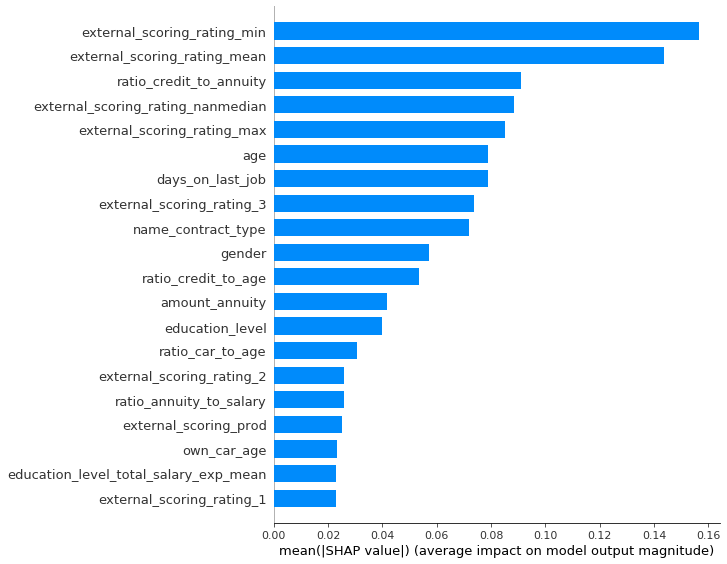

In [27]:
shap.summary_plot(shap_values, train, plot_type='bar')

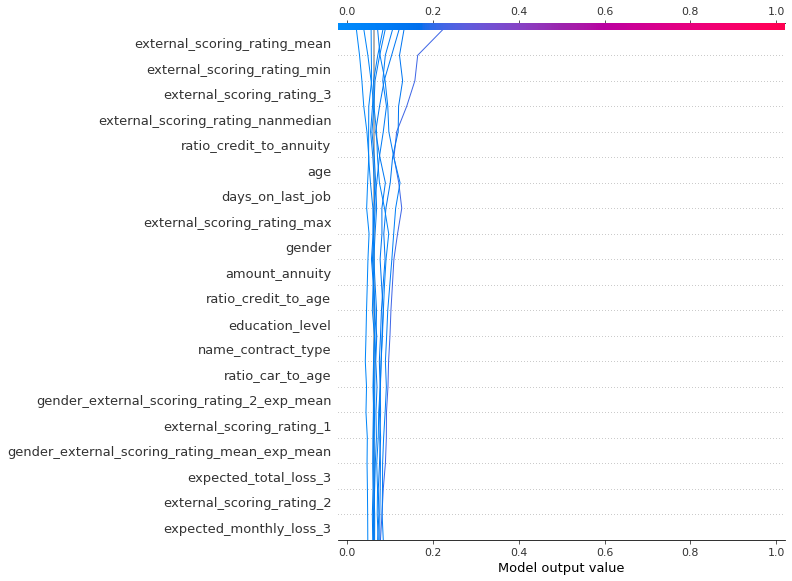

In [68]:
shap.decision_plot(explainer.expected_value, shap_values[:10, :], train.iloc[:10, :], link='logit')

In [28]:
vals = np.abs(shap_values).mean(0)
shap_feature_importance = pd.DataFrame(list(zip(train.columns,vals)),columns=['feature','shap_values'])
shap_feature_importance.sort_values(by=['shap_values'],ascending=False,inplace=True)

In [30]:
shap_feature_importance.tail(5)

,feature,shap_values
18,amt_req_credit_bureau_hour,0.002546
20,amt_req_credit_bureau_week,0.002326
21,amt_req_credit_bureau_mon,0.002227
19,amt_req_credit_bureau_day,0.002199
39,education_level_|_family_status,0.000390


## Оптимизация гиперпараметров

In [ ]:
def model_optimize_params(estimator, max_depth, min_child_weights, colsample_bytree, l2_leaf_reg):

    params["max_depth"] = int(max_depth)
    params["min_child_weights"] = int(min_child_weights)
    params["colsample_bytree"] = colsample_bytree
    params["l2_leaf_reg"] = l2_leaf_reg,
    model = xgb.train(
        params=params,
        dtrain=dtrain,
        evals=[(dtrain, "dtrain"), (dvalid, "dvalid")],
        early_stopping_rounds=25,
        num_boost_round=1000,
        verbose_eval=10,
        maximize=True,
    )

    return roc_auc_score(y_valid, model.predict(dvalid))

In [ ]:
params_search = {
    "max_depth": (5, 6, 7),
    "min_child_weights": (5, 500),
    "colsample_bytree": (0.3, 0.9),
    "l2_leaf_reg": (7, 10, 12)
}

model_params_search = BayesianOptimization(
    model_optimize_params,
    pbounds=params_search,
    random_state=27
)
model_params_search.maximize(
    init_points=3, n_iter=5, acq='ei'
)

In [ ]:
optimal_model_params = model_params_search.max

## Комбинации и ансамбли моделей

#### Оценка базового качества других моделей

In [19]:
xgb_params = {
    "n_estimators": 2000,
    "learning_rate": 0.01,
    "max_bin": 25,
    "max_depth": 6,
    "n_jobs": 6
}

cb_params = {
    "n_estimators": 2000,
    "learning_rate": 0.01,
    "loss_function": "Logloss",
    "task_type": "CPU",
    "max_bin": 25,
    "verbose": 0,
    "max_depth": 6,
    "l2_leaf_reg": 10,
    "thread_count": 6,
    "random_seed": 42
}

lgbm_params = {
    "n_estimators": 2000,
    "learning_rate": 0.01,
    "loss_function": "Logloss",
    "max_bin": 25,
    "verbose": 0,
    "max_depth": 6,
    "num_leaves": 25,
    "l2_leaf_reg": 10,
    "thread_count": 6,
    "random_seed": 42
}



models = ([XGBClassifier(**xgb_params),
           CatBoostClassifier(**cb_params),
           LGBMClassifier(**lgbm_params)])

model_names = ['xgboost', 'catboost', 'lightgbm']

for model, name in zip(models, model_names):
    score = roc_auc_cv(model, train, target)
    print("{}: {:.6f}, {:4f}".format(name, score.mean(), score.std()))

xgboost: 0.722138, 0.004915
0:	learn: 0.6824370	total: 62.4ms	remaining: 2m 4s
500:	learn: 0.2536042	total: 27.2s	remaining: 1m 21s
1000:	learn: 0.2486031	total: 55.3s	remaining: 55.1s
1500:	learn: 0.2442511	total: 1m 23s	remaining: 27.7s
1999:	learn: 0.2399390	total: 1m 49s	remaining: 0us
0:	learn: 0.6824225	total: 54.1ms	remaining: 1m 48s
500:	learn: 0.2534655	total: 27.2s	remaining: 1m 21s
1000:	learn: 0.2483013	total: 53.9s	remaining: 53.8s
1500:	learn: 0.2434370	total: 1m 20s	remaining: 26.7s
1999:	learn: 0.2387685	total: 1m 47s	remaining: 0us
0:	learn: 0.6824235	total: 62.8ms	remaining: 2m 5s
500:	learn: 0.2538914	total: 26.6s	remaining: 1m 19s
1000:	learn: 0.2487155	total: 52.8s	remaining: 52.7s
1500:	learn: 0.2436760	total: 1m 18s	remaining: 26.2s
1999:	learn: 0.2392638	total: 1m 44s	remaining: 0us
0:	learn: 0.6824329	total: 77.1ms	remaining: 2m 34s
500:	learn: 0.2535830	total: 27.4s	remaining: 1m 21s
1000:	learn: 0.2484776	total: 54.8s	remaining: 54.7s
1500:	learn: 0.2436723	t

In [20]:
# xgboost: 0.722138, 0.004915
# catboost: 0.723680, 0.004258
# lightgbm: 0.716865, 0.004014

In [25]:
train, test, target, test_id, _ = evaluator.split_data(data)
# train = train[:10000]
# target = target[:10000]
train.fillna(-9999,axis=1, inplace=True)
test.fillna(-9999,axis=1, inplace=True)
# train = RobustScaler().fit_transform(train)
# test = RobustScaler().fit_transform(test)
X_train, X_valid, y_train, y_valid = train_test_split(train, target, test_size=0.1)

In [ ]:
"""Стэкинг моделей"""

# train, test, target, test_id, _ = evaluator.split_data(data)

s_xgb_params = {
    "n_estimators": 3000,
    "learning_rate": 0.005,
    "max_bin": 25,
    "max_depth": 6,
    "n_jobs": 6
}

s_cb_params = {
    "n_estimators": 3000,
    "learning_rate": 0.005,
    "loss_function": "Logloss",
    "task_type": "CPU",
    "max_bin": 25,
    "verbose": 500,
    "max_depth": 6,
    "l2_leaf_reg": 10,
    "thread_count": 6,
    "random_seed": 42
}

        
s_lgbm_params = {
    "n_estimators": 3000,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.005,
    "loss_function": "Logloss",
    "max_bin": 25,
    "verbose": 500,
    "max_depth": 6,
    "num_leaves": 25,
    "l2_leaf_reg": 10,
    "thread_count": 6,
    "random_seed": 42,
    "n_jobs": 6
}

xxgb = XGBClassifier(**s_xgb_params)
xcatb = catb.CatBoostClassifier(**s_cb_params)
xlgbm = LGBMClassifier(**s_lgbm_params)


stack = StackingCVClassifier(classifiers=(xlgbm, xxgb, xcatb),
                            meta_classifier=xcatb, cv=5,
                            use_probas=True,
                            use_features_in_secondary=True,
                            store_train_meta_features=True,
                            shuffle=True,
                            random_state=42,
                            n_jobs=6)

stack.fit(X_train, y_train)

In [58]:
roc_auc_score(y_valid, stack.predict_proba(X_valid)[:, 1])

0.6810531270673249

In [ ]:
# 10k auc - 68.1

In [48]:
stack_pred = stack.predict_proba(test)[:, 1]

stack_pred = pd.DataFrame({
    "APPLICATION_NUMBER": test_id,
    "TARGET": stack_pred
})
stack_pred.to_csv("YN_#17.csv", index=False)